# Object Instance Segmentation 

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

Visual analysis of clothing is a topic that has received increasing attention in recent years. Being able to recognize apparel products and associated attributes from pictures could enhance the shopping experience for consumers, and increase work efficiency for fashion professionals.

A clothing dataset with the goal of introducing a novel fine-grained segmentation task by joining forces between the fashion and computer vision communities. The proposed task unifies both categorization and segmentation of rich and complete apparel attributes, an important step toward real-world applications.



In [ ]:
!unrar x -Y "/mnt/sda2/Datasets/iMaterialist_Data.rar" ".."

### Importing Libraries

In [ ]:
import os
import gc
import sys
import json

import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

### Clone the model repository

In [ ]:
!git clone https://github.com/akTwelve/Mask_RCNN
os.chdir('Mask_RCNN')
# !pip install -r requirements.txt
!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

### Define local variables

In [ ]:
DATA_DIR = Path('/mnt/sda2/Joice_Data/iMaterialist Data')
ROOT_DIR = Path('/mnt/sda2/Joice_Data')
NUM_CATS = 46 # no of categories
IMAGE_SIZE = 512 # image size

In [ ]:
sys.path.append(str(ROOT_DIR/'Model/Mask_RCNN'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

### Pretrained Weights

In [ ]:
# downlaod coco dataset weights

!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


### Configure the Model
Using the utility functions that comes with the model to tune it

In [ ]:
# Mask R-CNN has a load of hyperparameters. Tuning a few of them
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4# a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    DETECTION_MIN_CONFIDENCE = 0.5
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

## Prepare dataset

In [ ]:
with open(str(DATA_DIR/'label_descriptions.json')) as f: 
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [ ]:
print(len(label_names))

46


In [ ]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")
segment_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


In [ ]:
segment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333401 entries, 0 to 333400
Data columns (total 6 columns):
ImageId          333401 non-null object
EncodedPixels    333401 non-null object
Height           333401 non-null int64
Width            333401 non-null int64
ClassId          333401 non-null int64
AttributesIds    206410 non-null object
dtypes: int64(3), object(3)
memory usage: 15.3+ MB


In [ ]:
print("Total segments: ", len(segment_df))

Total segments:  333401


In [ ]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean().astype(int)
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45623


,EncodedPixels,ClassId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [ ]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

### Creating a dataset for this task

In [ ]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
            
        
        # Add images 
        ext = ".jpg"
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name) + ext, 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        """Return the data of the image."""
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID."""
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID."""
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/mnt/sda2/Joice_Data/iMaterialist Data/train/a0d6f156d19281a807f88b6a483a98c4.jpg', ['jacket', 'pants', 'shoe', 'shoe', 'sleeve', 'lapel', 'pocket', 'shirt, blouse', 'collar', 'tie'])


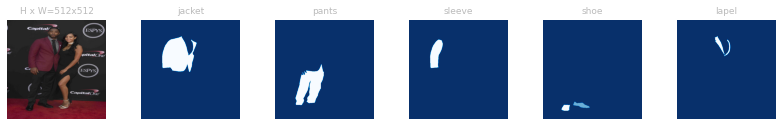

('/mnt/sda2/Joice_Data/iMaterialist Data/train/f23e7f812b84654c00728b0acae71a88.jpg', ['jacket', 'sleeve', 'sleeve', 'zipper', 'collar', 'dress', 'neckline', 'shoe', 'shoe', 'watch', 'bag, wallet', 'scarf'])


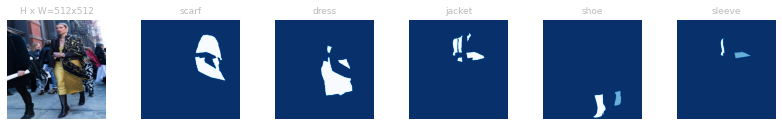

('/mnt/sda2/Joice_Data/iMaterialist Data/train/94ecd7466e8f27240b38fb7373a066d9.jpg', ['shoe', 'shoe', 'pants', 'cardigan', 'neckline', 'top, t-shirt, sweatshirt', 'sleeve', 'sleeve', 'collar', 'jacket', 'hat'])


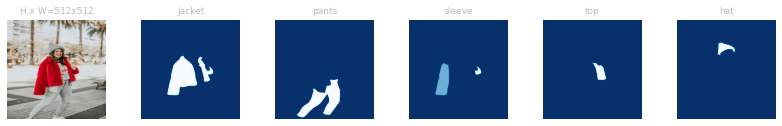

('/mnt/sda2/Joice_Data/iMaterialist Data/train/2e96458f56483f9e5d13c2f60f20dc95.jpg', ['shoe', 'pants', 'neckline', 'sleeve', 'top, t-shirt, sweatshirt', 'cardigan', 'sleeve'])


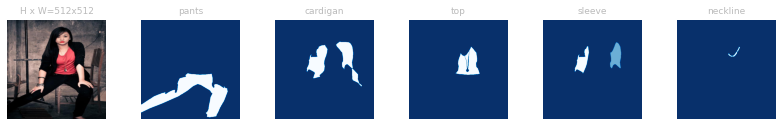

('/mnt/sda2/Joice_Data/iMaterialist Data/train/ca4f69a121230364a9145c5feb5889b0.jpg', ['belt', 'neckline', 'shoe', 'shoe', 'dress'])


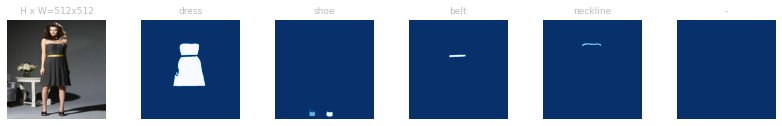

('/mnt/sda2/Joice_Data/iMaterialist Data/train/0ca49efba2d8bb2d8190f7fb69f225cb.jpg', ['sleeve', 'sleeve', 'shirt, blouse', 'buckle', 'belt', 'pocket', 'pocket', 'pants', 'watch', 'collar'])


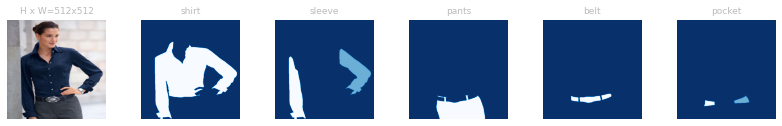

In [ ]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=5)

### Create folds

In [ ]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Total train images:  36498
Total train segments:  266792


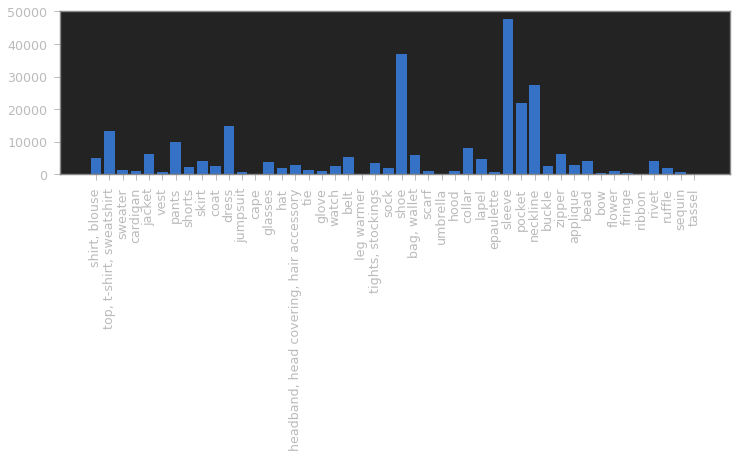

Total train images:  9125
Total validation segments:  66609


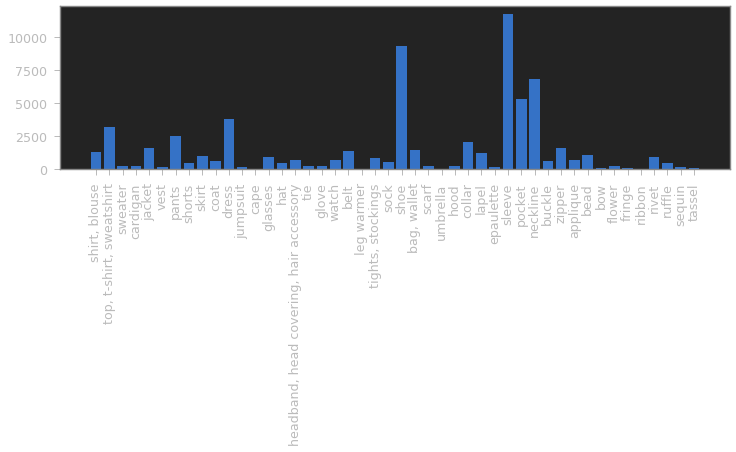

In [ ]:
train_segments = np.concatenate(train_df['ClassId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['ClassId'].values).astype(int)
print("Total train images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

In [ ]:
EPOCHS = 10
LR = 1e-4
COCO_WEIGHTS_PATH = str(ROOT_DIR/'Model/mask_rcnn_coco.h5')

In [ ]:
print(COCO_WEIGHTS_PATH)

/mnt/sda2/Joice_Data/Model/mask_rcnn_coco.h5


In [ ]:
os.chdir(ROOT_DIR/'Model')
!pwd

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config1 = tf.compat.v1.ConfigProto()
config1.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config1.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config1)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6



## Mask R-CNN

<img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-05-23_at_7.44.34_PM.png" width=500px>



Mask R-CNN is a state of the art model for instance segmentation, developed on top of Faster R-CNN. Faster R-CNN is a region-based convolutional neural networks, that returns bounding boxes for each object and its class label with a confidence score.

To understand Mask R-CNN, let's first discus architecture of Faster R-CNN that works in two stages:

Stage1: The first stage consists of two networks, backbone (ResNet, VGG, Inception, etc..) and region proposal network. These networks run once per image to give a set of region proposals. Region proposals are regions in the feature map which contain the object.

Stage2: In the second stage, the network predicts bounding boxes and object class for each of the proposed region obtained in stage1. Each proposed region can be of different size whereas fully connected layers in the networks always require fixed size vector to make predictions. Size of these proposed regions is fixed by using either RoI pool (which is very similar to MaxPooling) or RoIAlign method.



Faster R-CNN predicts object class and bounding boxes. Mask R-CNN is an extension of Faster R-CNN with additional branch for predicting segmentation masks on each Region of Interest (RoI).



In the second stage of Faster R-CNN, RoI pool is replaced by RoIAlign which helps to preserve spatial information which gets misaligned in case of RoI pool. RoIAlign uses binary interpolation to create a feature map that is of fixed size for e.g. 7 x 7.

The output from RoIAlign layer is then fed into Mask head, which consists of two convolution layers. It generates mask for each RoI, thus segmenting an image in pixel-to-pixel manner.


In [ ]:
import warnings 
warnings.filterwarnings("ignore")


model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR/'Model')

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name():
	print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
	print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


## Train

In [ ]:
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=2,
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /mnt/sda2/Joice_Data/Model/fashion20210716T2257/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv 

In [ ]:
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=6,
            layers='all',
            augmentation=none)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
model.train(train_dataset, valid_dataset,
            learning_rate=LR/5,
            epochs=10,
            layers='all',
            augmentation=none)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

### Visualize

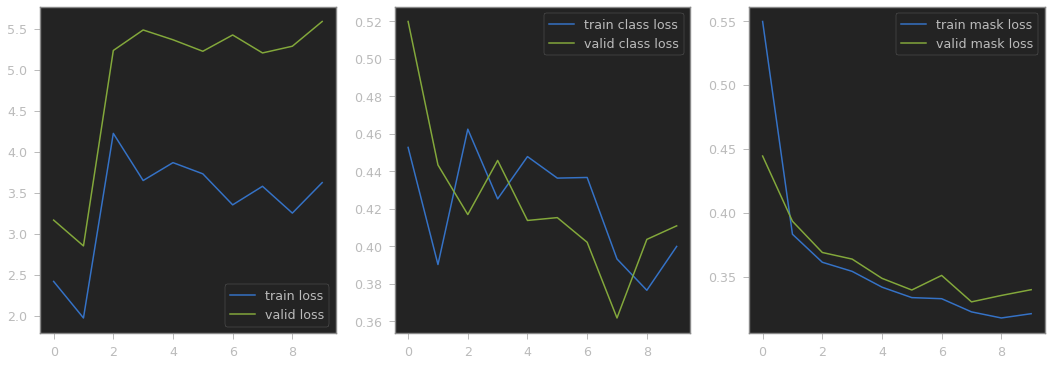

In [ ]:
epochs = range(EPOCHS)

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

In [ ]:
glob_list = glob.glob("fashion20210716T2130/mask_rcnn_fashion_0009.h5")
model_path=glob_list[0] if glob_list else ''

### Predict


In [ ]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR/'Model')


print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  fashion20210716T2130/mask_rcnn_fashion_0009.h5


In [ ]:
sample_df = pd.read_csv(DATA_DIR/"sample_submission.csv")
sample_df.head()

,ImageId,EncodedPixels,ClassId,AttributesIds
0,003d41dd20f271d27219fe7ee6de727d,1 1,0,"111,137"
1,0046f98599f05fd7233973e430d6d04d,1 1,0,"111,137"
2,004e9e21cd1aca568a8ffc77a54638ce,1 1,0,"111,137"
3,005b37fce3c0f641d327d95dd832f51b,1 1,0,"111,137"
4,0094940c58c343b742f48ae26eb5e9fa,1 1,0,"111,137"


In [ ]:
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [ ]:
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

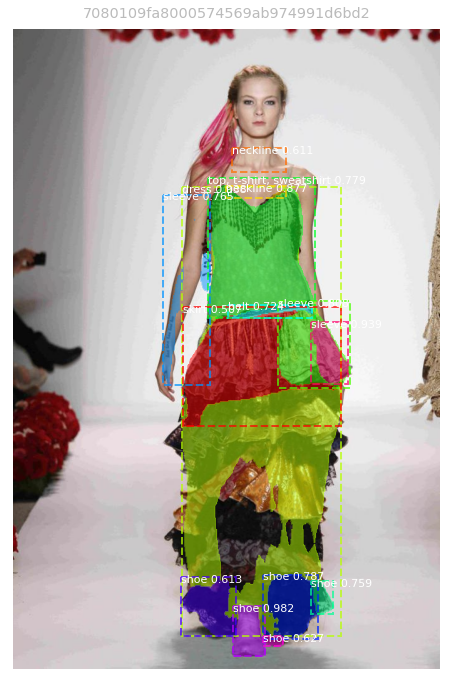

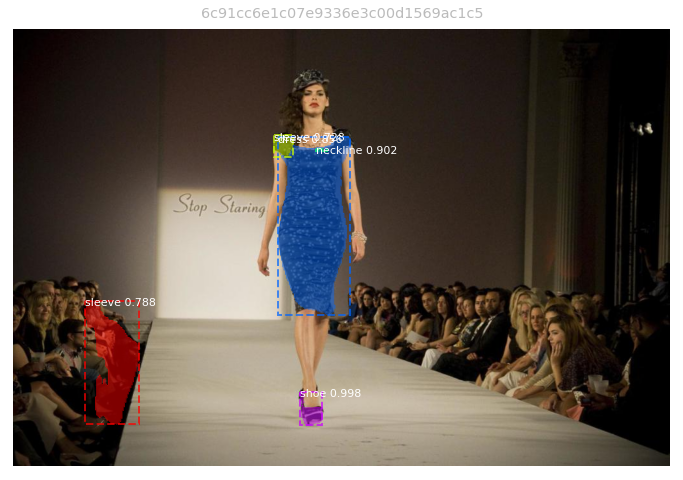

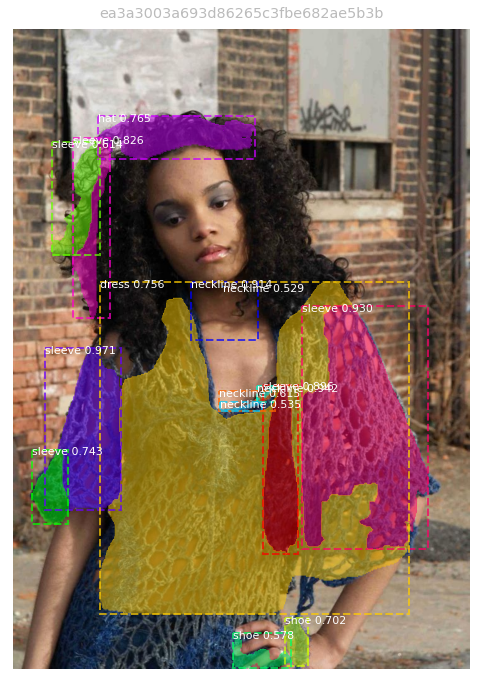

In [ ]:
ext = ".jpg"
for i in range(3):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id) + ext
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))